### Initialization

In [0]:
# For Colab only!

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import torch
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch import nn

In [3]:
print(tf.__version__)
print(tf.test.is_gpu_available())

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [4]:
print(torch.__version__)
print(torch.cuda.is_available())

1.4.0
True


### Data Loading
MINST data set

In [5]:
import numpy as np

batch_size=200
learning_rate=0.01
epochs=10

In [6]:
(x, y),(x_test, y_test) = keras.datasets.mnist.load_data()

ds_train = tf.data.Dataset.from_tensor_slices((x,y))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess(x, y):
  x = (tf.cast(x, tf.float32)/255)-0.1307
  y = tf.cast(y, tf.int32)
#   y = tf.one_hot(y,depth=10)   
  return x, y

ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size)
ds_test = ds_test.map(preprocess).shuffle(1000).batch(batch_size)


In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=True)

In [8]:
print(type(ds_test))
image, label = next(iter(ds_test))
print(image.shape, label.shape)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
(200, 28, 28) (200,)


In [9]:
print(type(train_loader))
[image, label] = next(iter(train_loader))
print(image.shape, label.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([200, 1, 28, 28]) torch.Size([200])


### Regularization
* Tensorflow: layers.Desnse set parameter `kernel_regularizer`
* Pytorch: optimizer parameter `weight_dacy`


In [0]:
class FC_model(keras.Model):
    def __init__(self):
        super().__init__()
    
        # Regulariztion applied here
        self.model = keras.Sequential(
            [layers.Dense(200, kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.ReLU(),
            layers.Dense(100,kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.ReLU(),
            layers.Dense(10)]
            )
    
    def call(self,x):
        x = self.model(x)
        
        return x
    
model = FC_model()
optimizer = tf.optimizers.Adam(learning_rate)
    
for epoch in range(epochs):
    
    for step, (x, y) in enumerate(ds_train):
        x = tf.reshape(x, [-1, 28*28])
        with tf.GradientTape() as tape:            
            logits = model(x)
            
            losses = tf.losses.sparse_categorical_crossentropy(y,logits,from_logits=True)
            loss = tf.reduce_mean(losses)
            
        grads = tape.gradient(loss, model.variables)
        
        optimizer.apply_gradients(zip(grads, model.variables))
        
        if(step%100==0):
            print("epoch:{}, step:{} loss:{}".
                  format(epoch, step, loss.numpy()))
            
            
#             test accuracy: 
            total_correct = 0
            total_num = 0
            
            for x_test, y_test in ds_test:
                x_test = tf.reshape(x_test, [-1, 28*28])
                y_pred = tf.argmax(model(x_test),axis=1)
                y_pred = tf.cast(y_pred, tf.int32)
                correct = tf.cast((y_pred == y_test), tf.int32)
                correct = tf.reduce_sum(correct)
                
                total_correct += int(correct)
                total_num += x_test.shape[0]
        
            
            accuracy = total_correct/total_num
            print('accuracy: ', accuracy)


epoch:0, step:0 loss:2.3325395584106445
accuracy:  0.2624
epoch:0, step:100 loss:0.2057160884141922
accuracy:  0.9387
epoch:0, step:200 loss:0.14280173182487488
accuracy:  0.9503
epoch:1, step:0 loss:0.20926254987716675
accuracy:  0.9531
epoch:1, step:100 loss:0.06743501871824265
accuracy:  0.9657
epoch:1, step:200 loss:0.2079378068447113
accuracy:  0.9671
epoch:2, step:0 loss:0.15533088147640228
accuracy:  0.9603
epoch:2, step:100 loss:0.11234745383262634
accuracy:  0.9693
epoch:2, step:200 loss:0.0930759608745575
accuracy:  0.9593
epoch:3, step:0 loss:0.13589558005332947
accuracy:  0.964
epoch:3, step:100 loss:0.055012188851833344
accuracy:  0.9626
epoch:3, step:200 loss:0.08367767184972763
accuracy:  0.9651
epoch:4, step:0 loss:0.0876694992184639
accuracy:  0.9662
epoch:4, step:100 loss:0.07405173033475876
accuracy:  0.9623
epoch:4, step:200 loss:0.2387072741985321
accuracy:  0.9656
epoch:5, step:0 loss:0.09264291822910309
accuracy:  0.9694
epoch:5, step:100 loss:0.02522336691617965

In [0]:
class FC_NN(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100,10)
            )
    
    def forward(self, x):
        x = self.model(x)
        
        return x
device = torch.device('cuda:0')

network = FC_NN().to(device)

# L2 regularization == weight_decay in the optimizers
optimizer = torch.optim.Adam(network.parameters(),
                            lr=learning_rate, weight_decay=0.01)
criteon = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    
    for step, (x, y) in enumerate(train_loader):
        x = x.reshape(-1,28*28)
        
        x, y = x.to(device), y.to(device)
        
        logits = network(x)
        loss = criteon(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(step%100 == 0):
            print("epoch:{}, step:{}, loss:{}".
                  format(epoch, step, loss.item()))
        
#             test accuracy
            total_correct = 0
            total_num = 0    

            for x_test, y_test in test_loader:
                    x_test = x_test.reshape(-1,28*28)
                    x_test, y_test = x_test.to(device), y_test.to(device)

                    y_pred = network(x_test)
                    y_pred = torch.argmax(y_pred, dim = 1)
                    correct = y_pred == y_test
                    correct = correct.sum()

                    total_correct += correct
                    total_num += x_test.shape[0]

            acc = total_correct.float()/total_num
            print("accuracy: ", acc.item())
                
                

epoch:0, step:0, loss:2.3211936950683594
accuracy:  0.35179999470710754
epoch:0, step:100, loss:0.3450058102607727
accuracy:  0.9012999534606934
epoch:0, step:200, loss:0.25054946541786194
accuracy:  0.904699981212616
epoch:1, step:0, loss:0.23051348328590393
accuracy:  0.9236999750137329
epoch:1, step:100, loss:0.18832090497016907
accuracy:  0.9197999835014343
epoch:1, step:200, loss:0.262503981590271
accuracy:  0.9164999723434448
epoch:2, step:0, loss:0.3107120394706726
accuracy:  0.9044999480247498
epoch:2, step:100, loss:0.2616995871067047
accuracy:  0.9297999739646912
epoch:2, step:200, loss:0.18142449855804443
accuracy:  0.9273999929428101
epoch:3, step:0, loss:0.28620439767837524
accuracy:  0.9300999641418457
epoch:3, step:100, loss:0.2452820986509323
accuracy:  0.941100001335144
epoch:3, step:200, loss:0.24611301720142365
accuracy:  0.9420999884605408
epoch:4, step:0, loss:0.2318108230829239
accuracy:  0.9275999665260315
epoch:4, step:100, loss:0.20092058181762695
accuracy:  0.

### Dropout

In [0]:
class FC_model(keras.Model):
    def __init__(self):
        super().__init__()
    
        self.model = keras.Sequential(
            [layers.Dense(200),
            layers.ReLU(),
            layers.Dropout(0.4),
            layers.Dense(100),
            layers.ReLU(),
            layers.Dropout(0.4),             
            layers.Dense(10)]
            )
    
    def call(self,x):
        x = self.model(x)
        
        return x
    
model = FC_model()
optimizer = tf.optimizers.Adam(learning_rate)
    
for epoch in range(epochs):
    
    for step, (x, y) in enumerate(ds_train):
        x = tf.reshape(x, [-1, 28*28])
        with tf.GradientTape() as tape:            
            logits = model(x)
            
            losses = tf.losses.sparse_categorical_crossentropy(y,logits,from_logits=True)
            loss = tf.reduce_mean(losses)
            
        grads = tape.gradient(loss, model.variables)
        
        optimizer.apply_gradients(zip(grads, model.variables))
        
        if(step%100==0):
            print("epoch:{}, step:{} loss:{}".
                  format(epoch, step, loss.numpy()))
            
            
#             test accuracy: 
            total_correct = 0
            total_num = 0
            
            for x_test, y_test in ds_test:
                x_test = tf.reshape(x_test, [-1, 28*28])
                y_pred = tf.argmax(model(x_test),axis=1)
                y_pred = tf.cast(y_pred, tf.int32)
                correct = tf.cast((y_pred == y_test), tf.int32)
                correct = tf.reduce_sum(correct)
                
                total_correct += int(correct)
                total_num += x_test.shape[0]
        
            
            accuracy = total_correct/total_num
            print('accuracy: ', accuracy)


epoch:0, step:0 loss:2.366990566253662
accuracy:  0.4342
epoch:0, step:100 loss:0.1408572494983673
accuracy:  0.9444
epoch:0, step:200 loss:0.1306784301996231
accuracy:  0.9476
epoch:1, step:0 loss:0.18211042881011963
accuracy:  0.9523
epoch:1, step:100 loss:0.1134713813662529
accuracy:  0.9645
epoch:1, step:200 loss:0.10413701087236404
accuracy:  0.9562
epoch:2, step:0 loss:0.10256875306367874
accuracy:  0.9589
epoch:2, step:100 loss:0.08379142731428146
accuracy:  0.9636
epoch:2, step:200 loss:0.06404948979616165
accuracy:  0.9685
epoch:3, step:0 loss:0.031297821551561356
accuracy:  0.9668
epoch:3, step:100 loss:0.06204662472009659
accuracy:  0.9681
epoch:3, step:200 loss:0.039909422397613525
accuracy:  0.9734
epoch:4, step:0 loss:0.12970837950706482
accuracy:  0.9707
epoch:4, step:100 loss:0.1105945035815239
accuracy:  0.9647
epoch:4, step:200 loss:0.1333925724029541
accuracy:  0.969
epoch:5, step:0 loss:0.0438968688249588
accuracy:  0.9689
epoch:5, step:100 loss:0.06427070498466492


In [0]:
class FC_NN(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(100,10)
            )
    
    def forward(self, x):
        x = self.model(x)
        
        return x
device = torch.device('cuda:0')

network = FC_NN().to(device)        
optimizer = torch.optim.Adam(network.parameters(),
                            lr=learning_rate)
criteon = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    
    for step, (x, y) in enumerate(train_loader):
        x = x.reshape(-1,28*28)
        
        x, y = x.to(device), y.to(device)
        
        logits = network(x)
        loss = criteon(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(step%100 == 0):
            print("epoch:{}, step:{}, loss:{}".
                  format(epoch, step, loss.item()))
        
#             test accuracy
            total_correct = 0
            total_num = 0    

            for x_test, y_test in test_loader:
                    x_test = x_test.reshape(-1,28*28)
                    x_test, y_test = x_test.to(device), y_test.to(device)

                    y_pred = network(x_test)
                    y_pred = torch.argmax(y_pred, dim = 1)
                    correct = y_pred == y_test
                    correct = correct.sum()

                    total_correct += correct
                    total_num += x_test.shape[0]

            acc = total_correct.float()/total_num
            print("accuracy: ", acc.item())
                
                

epoch:0, step:0, loss:2.3078196048736572
accuracy:  0.18709999322891235
epoch:0, step:100, loss:0.41146090626716614
accuracy:  0.8745999932289124
epoch:0, step:200, loss:0.33413898944854736
accuracy:  0.8973999619483948
epoch:1, step:0, loss:0.4246741235256195
accuracy:  0.8872999548912048
epoch:1, step:100, loss:0.39421287178993225
accuracy:  0.8986999988555908
epoch:1, step:200, loss:0.20466510951519012
accuracy:  0.8973999619483948
epoch:2, step:0, loss:0.40461957454681396
accuracy:  0.8955000042915344
epoch:2, step:100, loss:0.5728944540023804
accuracy:  0.9085999727249146
epoch:2, step:200, loss:0.17806629836559296
accuracy:  0.9031999707221985
epoch:3, step:0, loss:0.5936587452888489
accuracy:  0.9023000001907349
epoch:3, step:100, loss:0.30897387862205505
accuracy:  0.9096999764442444
epoch:3, step:200, loss:0.6682959198951721
accuracy:  0.9140999913215637
epoch:4, step:0, loss:0.3526836335659027
accuracy:  0.9041999578475952
epoch:4, step:100, loss:0.4131539463996887
accuracy: 

### Learing Rate Decay

In [0]:
class FC_model(keras.Model):
    def __init__(self):
        super().__init__()
    
        self.model = keras.Sequential(
            [layers.Dense(200),
            layers.ReLU(),
            layers.Dense(100),
            layers.ReLU(),             
            layers.Dense(10)]
            )
    
    def call(self,x):
        x = self.model(x)
        
        return x
    
model = FC_model()

# set initial learning rate and minimum learning rate
lr_init = 0.2
lr_min = 1e-6
lr_decay = 0.995

optimizer = tf.optimizers.SGD(learning_rate=lr_init)

global_step = 0

for epoch in range(epochs):
    
    for step, (x, y) in enumerate(ds_train):
        x = tf.reshape(x, [-1, 28*28])
        with tf.GradientTape() as tape:            
            logits = model(x)
            
            losses = tf.losses.sparse_categorical_crossentropy(y,logits,from_logits=True)
            loss = tf.reduce_mean(losses)
            
        grads = tape.gradient(loss, model.variables)
        
        # Decay learning rate here 
        if optimizer.learning_rate > lr_min:
          optimizer.learning_rate = optimizer.learning_rate * lr_decay
        
        optimizer.apply_gradients(zip(grads, model.variables))
        
        if(step%100==0):
            print("epoch:{}, step:{} loss:{}".
                  format(epoch, step, loss.numpy()))
            
            
#             test accuracy: 
            total_correct = 0
            total_num = 0
            
            for x_test, y_test in ds_test:
                x_test = tf.reshape(x_test, [-1, 28*28])
                y_pred = tf.argmax(model(x_test),axis=1)
                y_pred = tf.cast(y_pred, tf.int32)
                correct = tf.cast((y_pred == y_test), tf.int32)
                correct = tf.reduce_sum(correct)
                
                total_correct += int(correct)
                total_num += x_test.shape[0]
        
            
            accuracy = total_correct/total_num
            print('accuracy: ', accuracy, 'learing rate: ', optimizer.learning_rate.numpy())

        global_step += 1

epoch:0, step:0 loss:2.288949966430664
accuracy:  0.3045 learing rate:  0.199
epoch:0, step:100 loss:0.2368682622909546
accuracy:  0.902 learing rate:  0.12054837
epoch:0, step:200 loss:0.22905904054641724
accuracy:  0.9212 learing rate:  0.073024675
epoch:1, step:0 loss:0.26692017912864685
accuracy:  0.9255 learing rate:  0.044236213
epoch:1, step:100 loss:0.29251259565353394
accuracy:  0.9285 learing rate:  0.02679701
epoch:1, step:200 loss:0.27387234568595886
accuracy:  0.9313 learing rate:  0.01623284
epoch:2, step:0 loss:0.26345327496528625
accuracy:  0.9321 learing rate:  0.009833382
epoch:2, step:100 loss:0.28329917788505554
accuracy:  0.9322 learing rate:  0.005956773
epoch:2, step:200 loss:0.22056129574775696
accuracy:  0.9325 learing rate:  0.0036084396
epoch:3, step:0 loss:0.2406102567911148
accuracy:  0.9332 learing rate:  0.0021858872
epoch:3, step:100 loss:0.23601095378398895
accuracy:  0.9331 learing rate:  0.0013241466
epoch:3, step:200 loss:0.19479002058506012
accuracy

In [0]:
class FC_NN(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100,10)
            )
    
    def forward(self, x):
        x = self.model(x)
        
        return x
device = torch.device('cuda:0')

network = FC_NN().to(device)        
optimizer = torch.optim.SGD(network.parameters(),
                            lr=learning_rate)

# learing rate will drop with implovement with number (patience) of epsodes
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200)

criteon = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    
    for step, (x, y) in enumerate(train_loader):
        x = x.reshape(-1,28*28)
        
        x, y = x.to(device), y.to(device)
        
        logits = network(x)
        loss = criteon(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update learning rate here
        scheduler.step(loss)
        
        if(step%100 == 0):
            print("epoch:{}, step:{}, loss:{}".
                  format(epoch, step, loss.item()))
        
#             test accuracy
            total_correct = 0
            total_num = 0    

            for x_test, y_test in test_loader:
                    x_test = x_test.reshape(-1,28*28)
                    x_test, y_test = x_test.to(device), y_test.to(device)

                    y_pred = network(x_test)
                    y_pred = torch.argmax(y_pred, dim = 1)
                    correct = y_pred == y_test
                    correct = correct.sum()

                    total_correct += correct
                    total_num += x_test.shape[0]

            acc = total_correct.float()/total_num
            print("accuracy: ", acc.item(), "learning rate: ", optimizer.param_groups[0]['lr'])
                
                

epoch:0, step:0, loss:2.323620557785034
accuracy:  0.08709999918937683 learning rate:  0.01
epoch:0, step:100, loss:1.9669822454452515
accuracy:  0.66839998960495 learning rate:  0.01
epoch:0, step:200, loss:1.1098418235778809
accuracy:  0.7950999736785889 learning rate:  0.01
epoch:1, step:0, loss:0.6557897329330444
accuracy:  0.8479999899864197 learning rate:  0.01
epoch:1, step:100, loss:0.5625755786895752
accuracy:  0.8687999844551086 learning rate:  0.01
epoch:1, step:200, loss:0.5705286860466003
accuracy:  0.8807999491691589 learning rate:  0.01
epoch:2, step:0, loss:0.4688332676887512
accuracy:  0.8881999850273132 learning rate:  0.01
epoch:2, step:100, loss:0.3717648684978485
accuracy:  0.894599974155426 learning rate:  0.01
epoch:2, step:200, loss:0.36960285902023315
accuracy:  0.8983999490737915 learning rate:  0.01
epoch:3, step:0, loss:0.37219443917274475
accuracy:  0.9024999737739563 learning rate:  0.001
epoch:3, step:100, loss:0.4337742328643799
accuracy:  0.903299987316

In [0]:
import matplotlib.pyplot as plt

Plot learning rate decay

In [0]:
# Maximun global_step about 3000

lr = 0.2
min_lr = 1e-6

global_step = 0
decay_rate = 0.995

recoder = {"lr":[],"global_step":[]}


for epoch in range(epochs):
    
    for step, (x, y) in enumerate(ds_train):
      recoder['lr'].append(lr) 
      recoder['global_step'].append(global_step)
      
      # if lr > min_lr:
      lr = lr * decay_rate

      global_step += 1

      

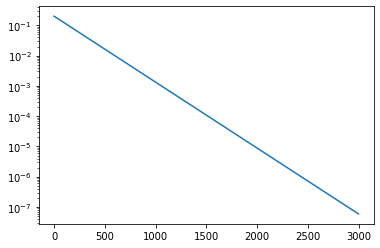

In [0]:
plt.plot(recoder['global_step'],recoder['lr'])
plt.yscale('log')